<a href="https://colab.research.google.com/github/log-ghj/simulation-exercises/blob/main/Advanced_Econometrics_Simulation_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook includes some implementations of random number generators, Monte
Carlo experiments, bootstrapping,...
shown by Prof. Flachaire in his class "Advanced Econometrics: Simulation 
Methods" (lecture slides can be found on Prof. Flachaire's [website](https://sites.google.com/site/emmanuelflachaire/cours/advanced_econometrics))at AMSE (fall semester 2020). Prof. Flachaire used R to illustrate the concepts with examples, I repeated his examples in Python for practice.

In [ ]:
# Start with some imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import uniform, norm, genpareto, burr12
from numba import njit, prange
import statsmodels.api as sm
from tqdm import tqdm_notebook as tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
'''
Pseudo-random generator

This cell plots the simulated and true PDF for four distributions
'''

fig, ax = plt.subplots(4, figsize=(10, 24))
n= 100_000
distributions = (uniform(loc=1, scale=1),
                 norm(loc=2, scale=3),
                 burr12(c=2, d=2),
                 genpareto(c=2, loc=1, scale=2))

for ax, distribution in zip(ax.ravel(), distributions):
  data = distribution.rvs(size=n)
  
  if max(data)<50:
    ax.hist(data, bins=100, alpha=0.5, density=True, range=(min(data), max(data)))
    xgrid = np.linspace(min(data), max(data),200)
  
  else:
    ax.hist(data, bins=100, alpha=0.5, density=True, range=(min(data), 50))
    xgrid = np.linspace(min(data), 50, 200)
  
  ax.plot(xgrid, distribution.pdf(x=xgrid))

In [ ]:
'''
Monte Carlo experiments

This cell contains a function for computing Monte Carlo experiments of the mean 
of a combined normal distribtution.
'''

@njit(parallel=True)
def Monte_Carlo_mixture(n, obs):
  M=np.empty(n)
  for num in prange(n):
    p=np.empty(obs)
    X=np.empty(obs)
    for nobs in prange(obs):
      random_uniform=np.random.random()
      p[nobs]=random_uniform
      if p[nobs]<=0.7:
        x=p[nobs]*np.random.normal(loc=-1, scale=0.4)
      elif p[nobs]>0.7:
        x=p[nobs]*np.random.normal(loc=1, scale=0.4)
      X[nobs]=x
    m=np.mean(X)
    M[num]=m
  return M

In [ ]:
'''
Defining a plotting function for four different numbers of observations with 
one million draws each.
'''
def plotting(simulation):
  observations = (10, 50, 100, 500)
  fig, ax = plt.subplots(4, figsize=(10, 24))
  for i, observation in enumerate(observations):
    data=simulation(1_000_000, observation)
    ax[i].hist(data, alpha=0.5, bins=120, density=True)
    values=np.linspace(min(data), max(data))
    distribution=norm(loc=np.mean(data), scale=np.std(data))
    ax[i].plot(values, distribution.pdf(values))

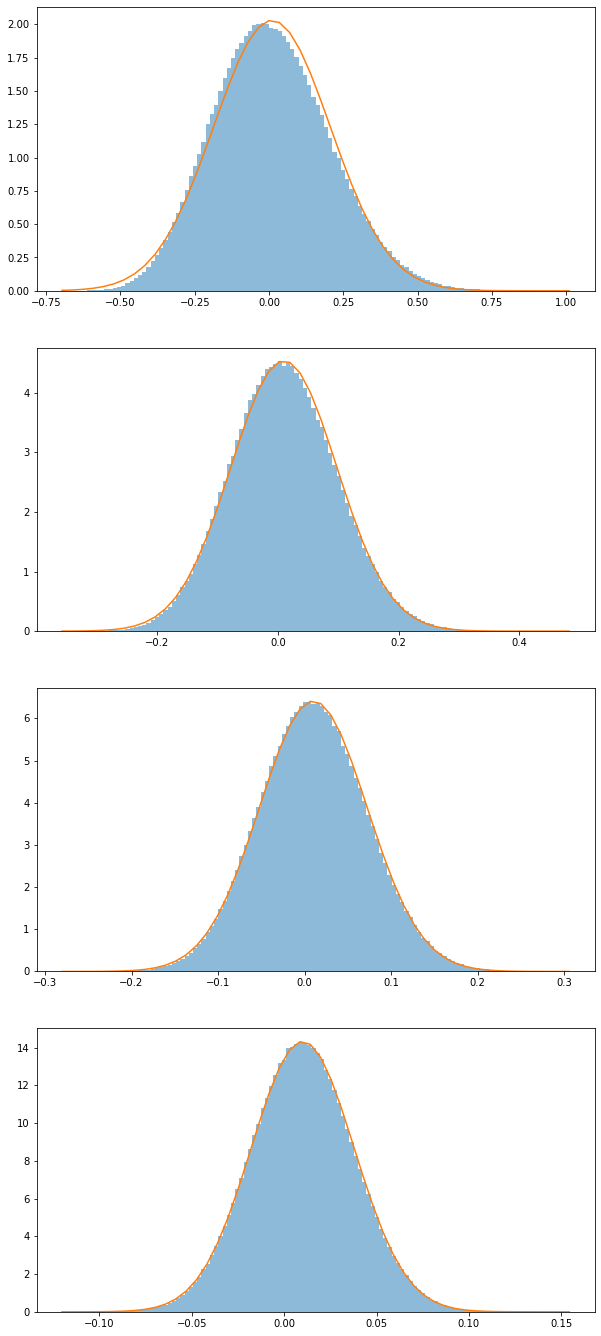

In [ ]:
# Monte Carlo experiment: sample average of x ∼ mixture
# Illustrating the fast convergence of this bimodal distribution
plotting(Monte_Carlo_mixture)

In [ ]:
@njit(parallel=True)
def Monte_Carlo_lognormal(n, obs):
  M=np.empty(n)
  for num in prange(n):
    X=np.empty(obs)
    for nobs in prange(obs):
      x=np.random.lognormal()
      X[nobs]=x
    m=np.mean(X)
    M[num]=m
  return M

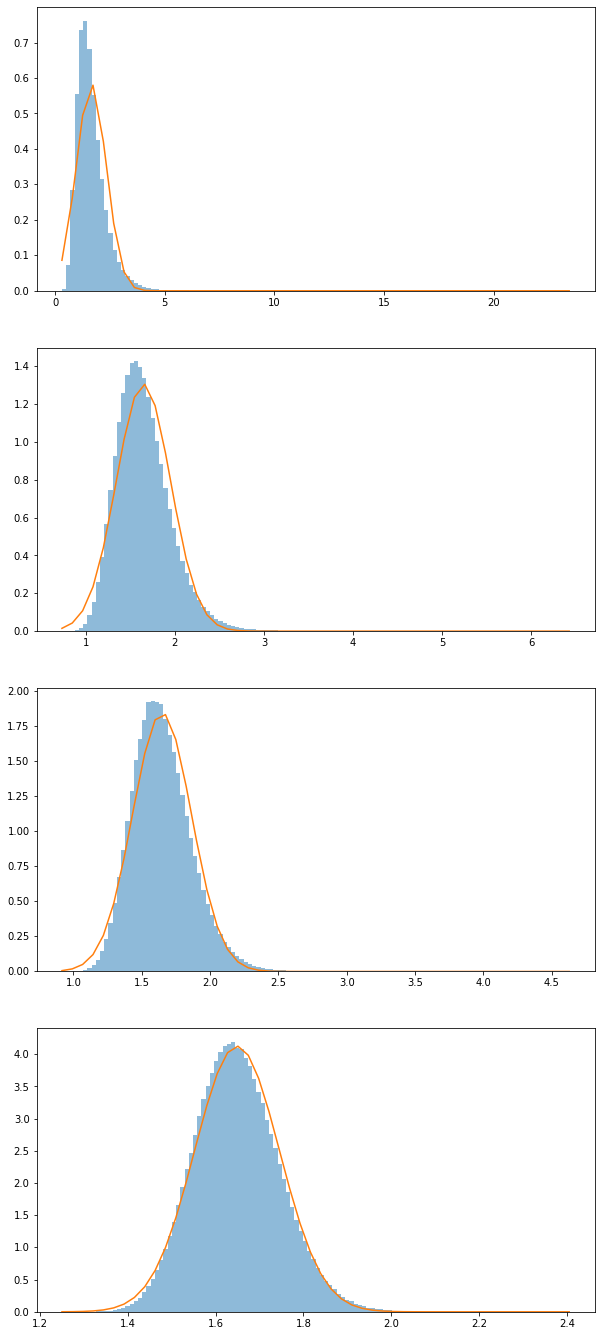

In [ ]:
# Monte Carlo experiment: sample average of x ∼ lognormal
# Illustrating the slower convergence
plotting(Monte_Carlo_lognormal)

In [ ]:
# MC experiments in regression: t-stat
'''
 left to do: code regression in np s.t. I can use jit here as well
''' 
# hard-coded the error for the plotting function


def Monte_Carlo_regression(n, obs):
  T=np.empty(n)
  
  for num in prange(n):
    Y=np.empty(obs)
    X=np.empty(obs)
    Eps=np.empty(obs)
    for nobs in prange(obs):
      x=np.random.lognormal()
      X[nobs]=x
      u=np.random.random()
      if u>0.5:                                   # epsilon ~ bi-atomic
        eps=1
      else:
        eps=-1
      Eps[nobs]=eps
      y=1+2*x+eps
      Y[nobs]=y
    X=sm.add_constant(X, prepend=False)
    mod=sm.OLS(Y, X)        
    res=mod.fit()
    t=(res.params[0]-2)/res.bse[0] 
    T[num]=t

  return T

In [ ]:
def plotting_for_nonjit(simulation):
  n=50_000
  obs=100
  fig, ax = plt.subplots(figsize=(10, 6))
  data=simulation(n, obs)
  ax.hist(data, alpha=0.5, bins=120, density=True)
  values=np.linspace(min(data), max(data))
  distribution=norm(loc=0, scale=1)
  ax.plot(values, distribution.pdf(values))

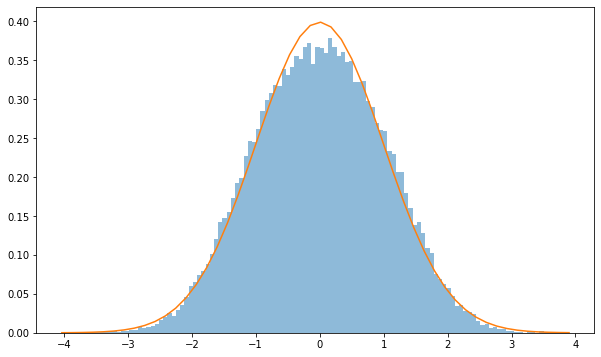

In [ ]:
plotting_for_nonjit(Monte_Carlo_regression)

In [ ]:
# MC experiment: t-stat based on robust standard error

def Monte_Carlo_regression_robust(n, obs):
  T=np.empty(n)
  
  for num in prange(n):
    Y=np.empty(obs)
    X=np.empty(obs)
    Eps=np.empty(obs)
    for nobs in prange(obs):
      x=np.random.lognormal()
      X[nobs]=x
      u=np.random.random()
      if u>0.5:
        eps=1
      else:
        eps=-1
      Eps[nobs]=eps
      y=1+2*x+eps
      Y[nobs]=y
    X=sm.add_constant(X, prepend=False)
    mod=sm.OLS(Y, X)        
    res=mod.fit()
    t=(res.params[0]-2)/res.HC3_se[0]            # only change to non-robust
    T[num]=t

  return T

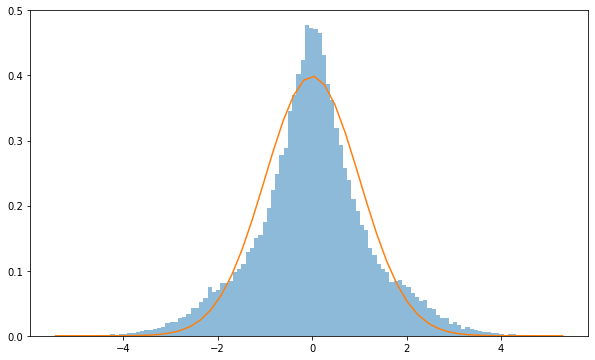

In [ ]:
plotting_for_nonjit(Monte_Carlo_regression_robust)

In [ ]:
# MC experiment: coverage of confidence interval
# Did the exercise for all four robust s.e. included in statsmodels
def Monte_Carlo_CI_coverage(n, obs):
  C=np.empty((n,10))
  for num in prange(n):
    Y=np.empty(obs)
    X=np.empty(obs)
    Eps=np.empty(obs)
    for nobs in prange(obs):
      x=np.random.lognormal()
      X[nobs]=x
      u=np.random.random()
      if u>0.5:                                   # epsilon ~ bi-atomic
        eps=1
      else:
        eps=-1
      Eps[nobs]=eps
      y=1+2*x+eps
      Y[nobs]=y
    X=sm.add_constant(X, prepend=False)
    mod=sm.OLS(Y, X)        
    res=mod.fit()
    errors=[res.bse[0], res.HC0_se[0], res.HC1_se[0], res.HC2_se[0], res.HC3_se[0]]
    for i, error in enumerate(errors):
      C[num,i]=res.params[0]+1.96*error
      C[num,i+5]=res.params[0]-1.96*error
  
  count=np.empty(5)
  for x in range(5):
    count[x]=np.count_nonzero(np.logical_and(C[:,x]>2, C[:,x+5]<2))
  
  coverage_OLS=count[0]/n
  coverage_rob1=count[1]/n
  coverage_rob2=count[2]/n
  coverage_rob3=count[3]/n
  coverage_rob4=count[4]/n

  return coverage_OLS, coverage_rob1, coverage_rob2, coverage_rob3, coverage_rob4

In [ ]:
Monte_Carlo_CI_coverage(10_000, 100)

(0.9517, 0.8446, 0.8474, 0.8606, 0.8815)

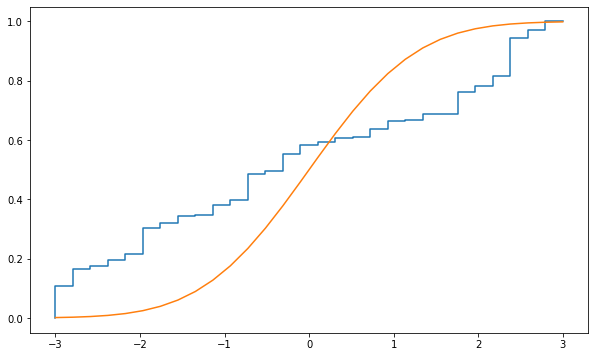

In [ ]:
'''
Bootstrap and permutation tests

'''

# Empirical Distribution Function (EDF)
X=np.random.normal(size=30)
fig, ax = plt.subplots(figsize=(10, 6))
data=sorted(X)
X_values=(data-min(data))/(max(data)-min(data))
values=np.linspace(-3, 3, 30)
ax.step(values, X_values)
distribution=norm(loc=0, scale=1)
ax.plot(values, distribution.cdf(values))

In [ ]:
# Bootstrap distribution for the mean

def bootstrap_mean(n,obs):

  X=np.empty(obs)
  for nobs in prange(obs):
    x=np.random.lognormal()
    X[nobs]=x
  
  M=np.empty(n)
  for num in prange(n):
    Xb=np.random.choice(X, obs, replace=True)
    m=np.mean(Xb)
    M[num]=m
  
  for num in prange(n):
    M[num]=M[num]-np.mean(M)+np.mean(X)

  return M, X

In [ ]:
def plot_bootstrap_mean(n,obs, plot_number=1):
  fig, ax = plt.subplots(plot_number+1, figsize=(10, plot_number*8))
  data_mc=Monte_Carlo_lognormal(n,obs)
  for num in range(plot_number):
    simulation=bootstrap_mean(n, obs)
    data=simulation[0]
    data_X=simulation[1]
    ax[num].hist(data, alpha=0.5, bins=120, density=True)
    values=np.linspace(min(data_X), max(data_X))
    distribution=norm(loc=np.mean(data_X), scale=np.std(data_X)/np.sqrt(obs))
    ax[num].plot(values, distribution.pdf(values))
    ax[num].set_xlim([min(data), max(data)])
    ax[num].axvline(np.mean(data_mc))
    ax[num].scatter(np.mean(data),0)
  ax[plot_number].hist(data_mc, alpha=0.5, bins=120, density=True)
  values_mc=np.linspace(min(data_mc), max(data_mc))
  distribution=norm(loc=np.mean(data_mc), scale=np.std(data_mc))
  ax[plot_number].plot(values_mc, distribution.pdf(values_mc))
  ax[plot_number].axvline(np.mean(data_mc))
  ax[plot_number].scatter(np.mean(data_mc),0)

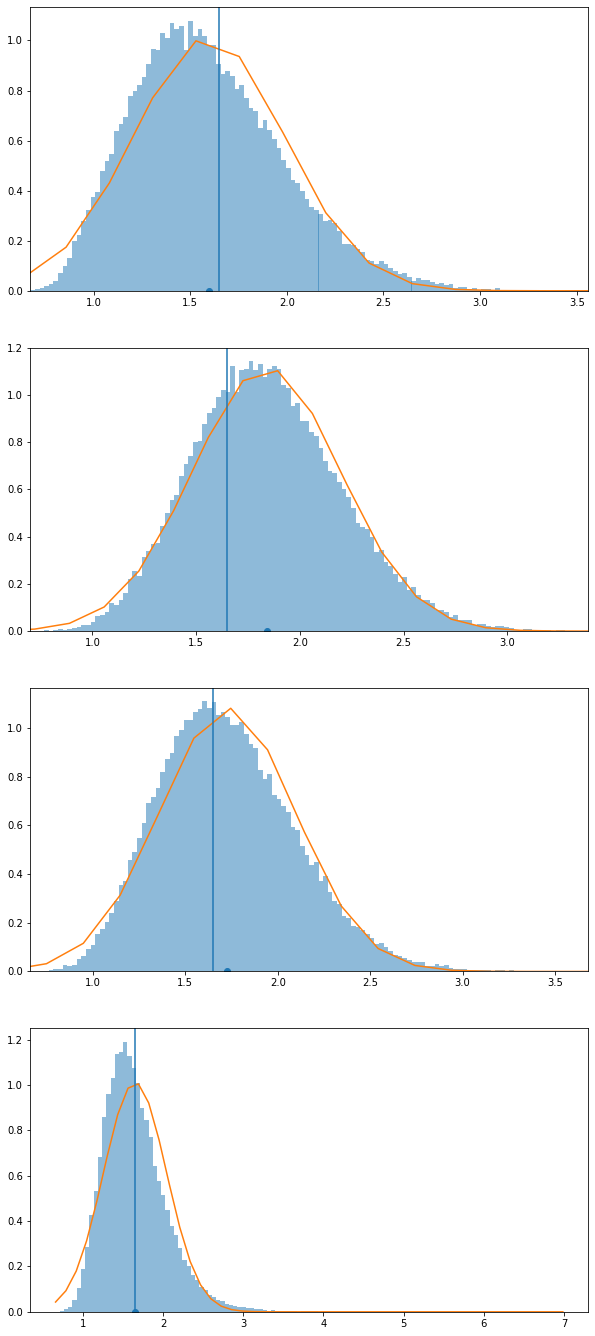

In [ ]:
plot_bootstrap_mean(50_000, 30, plot_number=3)

In [ ]:
# Bootstrap distribution for the median

def bootstrap_median(n,obs):

  X=np.empty(obs)
  for nobs in prange(obs):
    x=np.random.lognormal()
    X[nobs]=x
  
  M=np.empty(n)
  for num in prange(n):
    Xb=np.random.choice(X, obs, replace=True)
    m=np.median(Xb)
    M[num]=m
  
  for num in prange(n):
    M[num]=M[num]-np.mean(M)+np.median(X)

  return M, X

In [ ]:
@njit(parallel=True)
def Monte_Carlo_lognormal_median(n, obs):
  M=np.empty(n)
  for num in prange(n):
    X=np.empty(obs)
    for nobs in prange(obs):
      x=np.random.lognormal()
      X[nobs]=x
    m=np.median(X)
    M[num]=m
  return M

In [ ]:
def plot_bootstrap_median(n,obs, plot_number=1):
  fig, ax = plt.subplots(plot_number+1, figsize=(10, plot_number*8))
  data_mc=Monte_Carlo_lognormal_median(n,obs)
  for num in range(plot_number):
    simulation=bootstrap_median(n, obs)
    data=simulation[0]
    data_X=simulation[1]
    ax[num].hist(data, alpha=0.5, bins=120, density=True)
    values=np.linspace(min(data_X), max(data_X))
    distribution=norm(loc=np.mean(data_X), scale=np.std(data_X)/np.sqrt(obs))
    ax[num].plot(values, distribution.pdf(values))
    ax[num].set_xlim([min(data), max(data)])
    ax[num].axvline(np.median(data_mc))
    ax[num].scatter(np.median(data),0)
  ax[plot_number].hist(data_mc, alpha=0.5, bins=120, density=True)
  values_mc=np.linspace(min(data_mc), max(data_mc))
  distribution=norm(loc=np.mean(data_mc), scale=np.std(data_mc))
  ax[plot_number].plot(values_mc, distribution.pdf(values_mc))
  ax[plot_number].axvline(np.median(data_mc))
  ax[plot_number].scatter(np.median(data_mc),0)

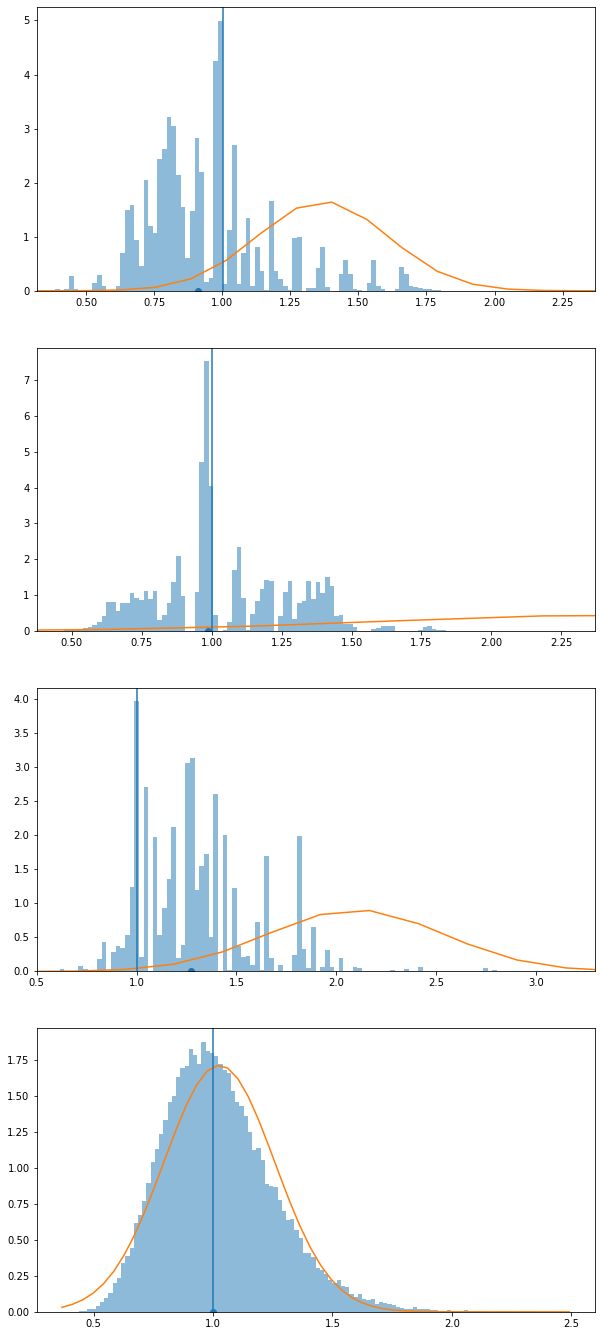

In [ ]:
plot_bootstrap_median(50_000, 30, plot_number=3)

In [ ]:
# Bootstrap distribution: t-stat based on robust s.e.

def bootstrap_regression_robust(n, obs):
  Y=np.empty(obs)
  X=np.empty(obs)
  for nobs in prange(obs):
    x=np.random.lognormal()
    X[nobs]=x
    u=np.random.random()
    if u>0.5:                                     # epsilon ~ bi-atomic
      eps=1
    else:
      eps=-1
    Y[nobs]=1+2*x+eps

  # Initial regression
  mod=sm.OLS(Y, sm.add_constant(X, prepend=False))        
  result=mod.fit()
  coef=result.params[0]
  res=result.resid                                # initial residuals
  t=(coef-2)/result.HC3_se[0]                     # initial t-statistic
  
  # Preparation for bootstrap
  T=np.empty(n)
  T[0]=t
  Yb=np.empty(obs)
  Resb=np.empty(obs)
  for nobs in prange(obs):
    Yb[nobs]=coef+2*X[nobs]+res[nobs]
    Resb[nobs]=res[nobs]

  # Bootstrapping
  for num in tqdm(prange(n-1)):                   # added a completion bar here
    resb=np.random.choice(Resb, size=obs,replace=True)
    for nobs in prange(obs):
      Yb[nobs]=coef+2*X[nobs]+resb[nobs]
    mod=sm.OLS(Yb, sm.add_constant(X, prepend=False))        
    result=mod.fit()
    res=result.resid
    t=(result.params[0]-2)/result.HC3_se[0]
    T[num+1]=t

  return T

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


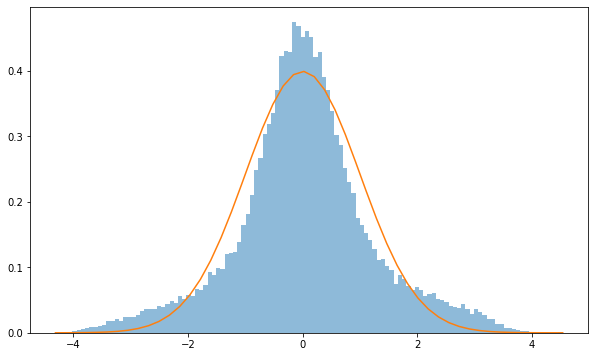

In [ ]:
plotting_for_nonjit(bootstrap_regression_robust)

In [ ]:
# Permutation test for the difference in means
def permutation_mean(n,m,rep,print=True):
  X=np.empty(n)
  Y=np.empty(m)
  for num in prange(n):
    x=np.random.lognormal()
    X[num]=x
  for num in prange(m):
    y=np.random.lognormal()
    Y[num]=y
  t0=np.mean(X)-np.mean(Y)
  st0=t0/(np.sqrt(np.var(X)/n+np.var(Y)/m))
  p=2*1/np.sqrt(2*np.pi)*np.e**(-0.5)*(-np.abs(st0))**2 #write down the formula for the pdf for later use with numba
  
  t=np.empty(rep)
  for num in prange(rep):
    Zp=np.random.choice(np.append(X,Y),size=(2,n), replace=False)
    t[num]=np.mean(Zp[0])-np.mean(Zp[1])
  p_value=np.count_nonzero(t>np.abs(t0))/rep+np.count_nonzero(t<(-np.abs(t0)))/rep
  if print==True:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(t, alpha=0.5, bins=120, density=True)
    ax.axvline(t0)
  return p, p_value

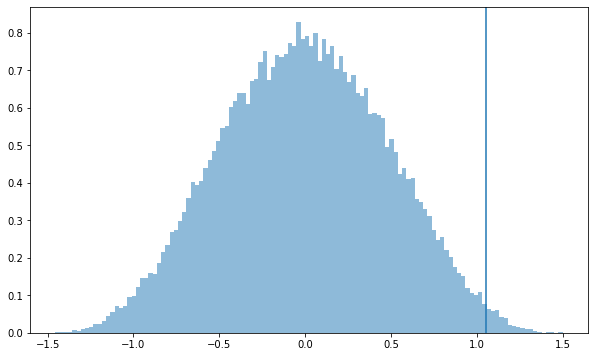

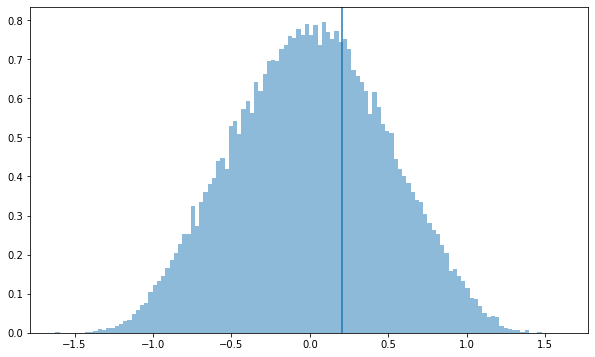

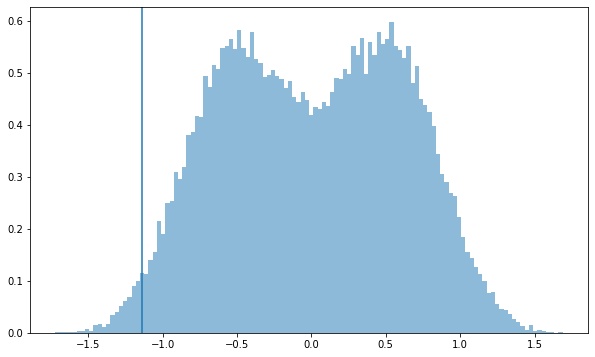

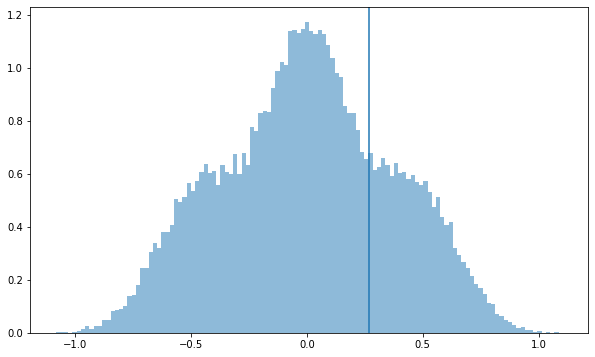

In [ ]:
for i in prange(4):
  permutation_mean(30,30,50_000)

In [ ]:
# Monte Carlo experiment: Are permutation tests exact?
@njit(parallel=True)
def MC_perm(n,m,nperm,nrepet):
  p1=np.empty(nrepet)
  p2=np.empty(nrepet)
  t=np.empty(nperm)
  X=np.empty(n)
  Y=np.empty(m)

  for j in prange(nrepet):
    for num in prange(n):
      x=np.random.lognormal()
      X[num]=x
    for num in prange(m):
      y=np.random.lognormal()
      Y[num]=y
    
    s0=(np.mean(X)-np.mean(Y))/np.sqrt(np.var(X)/n+np.var(Y)/m)
    p1[j]=1/np.sqrt(2*np.pi)*np.e**((-0.5)*(-np.abs(s0))**2)     #asymptotic p-value

    for i in prange(nperm):
      Zp=np.random.choice(np.append(X,Y), size=(2,n), replace=False)
      t[i]=np.mean(Zp[0])-np.mean(Zp[1])

    t0=np.mean(X)-np.mean(Y)                                    
    p2[j]=np.count_nonzero(t>np.abs(t0))/nperm+np.count_nonzero(t<(-np.abs(t0)))/nperm  #permutation p-value
  
  RP1=np.count_nonzero(p1<0.05)/nrepet
  RP2=np.count_nonzero(p2<0.05)/nrepet

  return RP1, RP2

In [ ]:
MC_perm(30,30,500,50_000)

(0.0405, 0.05602)

In [ ]:
def perm(n,m,nrepet,nperm):
  p1=np.empty(nrepet)
  p2=np.empty(nrepet)
  t=np.empty(nperm)
  for j in range(nrepet):
    X=np.random.lognormal(0,1,n)
    Y=np.random.lognormal(0,1,m)
    s0=(np.mean(X)-np.mean(Y))/np.sqrt(np.var(X)/n+np.var(Y)/m)
    p1[j]=2*norm.pdf(-np.abs(s0))                           #asymptotic p-value
    for i in range(nperm):
      Zp=np.concatenate((X,Y))
      np.random.shuffle(Zp)
      t[i]=np.mean(Zp[:n])-np.mean(Zp[n:])
    t0=np.mean(X)-np.mean(Y)
    p2[j]=np.count_nonzero(t>np.abs(t0))/nperm+np.count_nonzero(t<(-np.abs(t0)))/nperm  #permutation p-value
  RP1=np.count_nonzero(p1<0.05)/nrepet
  RP2=np.count_nonzero(p2<0.05)/nrepet
  return RP1, RP2

In [ ]:
perm(30,30,50_000,500)

(0.01652, 0.05012)